In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average




In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
model1 = load_model('CNN.Model')
model2 = load_model('TransferLearning.Model')
model3 = load_model('Inceptionv3.Model')

In [7]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [9]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [10]:
train_size = 0.8
len(dataset)*train_size

1032.0

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

1236

In [13]:
val_size = 0.1
len(dataset)*val_size

129.0

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
val_ds = test_ds.skip(6)
len(val_ds)

1230

In [16]:
models = [model1, model2, model3]
model_input = Input(shape=( 256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name = 'ensemble' ) 

In [17]:
ensemble_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [18]:
history = ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 352s 6s/step - loss: 0.5988 - accuracy: 0.9433 - val_loss: 0.4983 - val_accuracy: 0.9670
Epoch 2/50
54/54 [==============================] - 326s 6s/step - loss: 0.4448 - accuracy: 0.9745 - val_loss: 0.4547 - val_accuracy: 0.9670
Epoch 3/50
54/54 [==============================] - 325s 6s/step - loss: 0.4208 - accuracy: 0.9780 - val_loss: 0.4272 - val_accuracy: 0.9744
Epoch 4/50
54/54 [==============================] - 325s 6s/step - loss: 0.3784 - accuracy: 0.9884 - val_loss: 0.4237 - val_accuracy: 0.9777
Epoch 5/50
54/54 [==============================] - 325s 6s/step - loss: 0.3672 - accuracy: 0.9954 - val_loss: 0.4143 - val_accuracy: 0.9795
Epoch 6/50
54/54 [==============================] - 325s 6s/step - loss: 0.3614 - accuracy: 0.9942 - val_loss: 0.4181 - val_accuracy: 0.9789
Epoch 7/50
54/54 [==============================] - 324s 6s/step - loss: 0.3592 - accuracy: 0.9919 - val_loss: 0.4104 - val_accuracy: 0.9825
Epoch 8/50
54

In [19]:
scores = ensemble_model.evaluate(test_ds)

1236/1236 [==============================] - 315s 255ms/step - loss: 0.4041 - accuracy: 0.9828


In [20]:
tf.keras.models.save_model(ensemble_model, "EnsembleLearning.Model")

INFO:tensorflow:Assets written to: EnsembleLearning.Model\assets


C:\Users\tunce\anaconda3\envs\Gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [21]:
scores

[0.4040790796279907, 0.9827551245689392]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
history.history['loss'][:5]

[0.5988353490829468,
 0.4448404610157013,
 0.42081356048583984,
 0.3783961832523346,
 0.3671671152114868]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

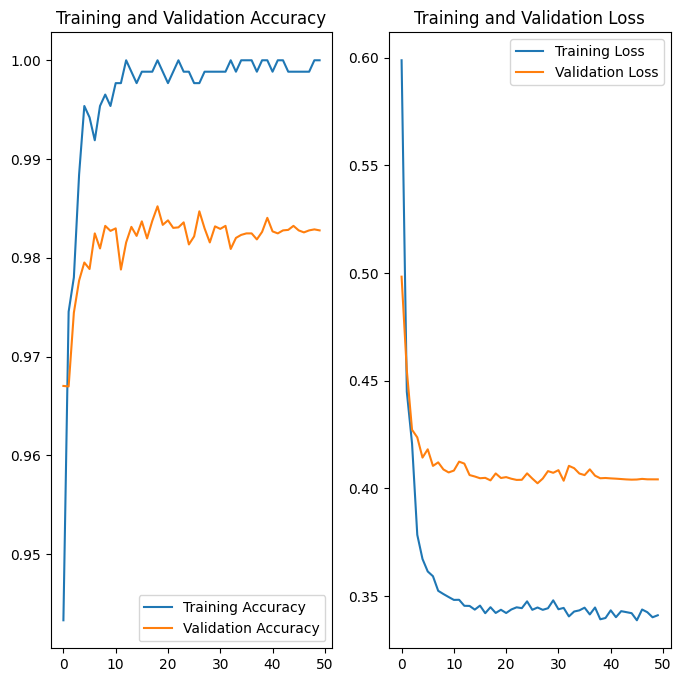

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


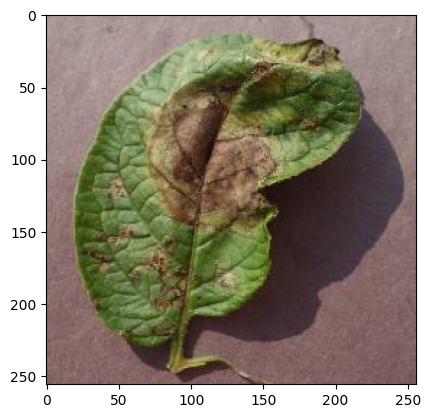

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = ensemble_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

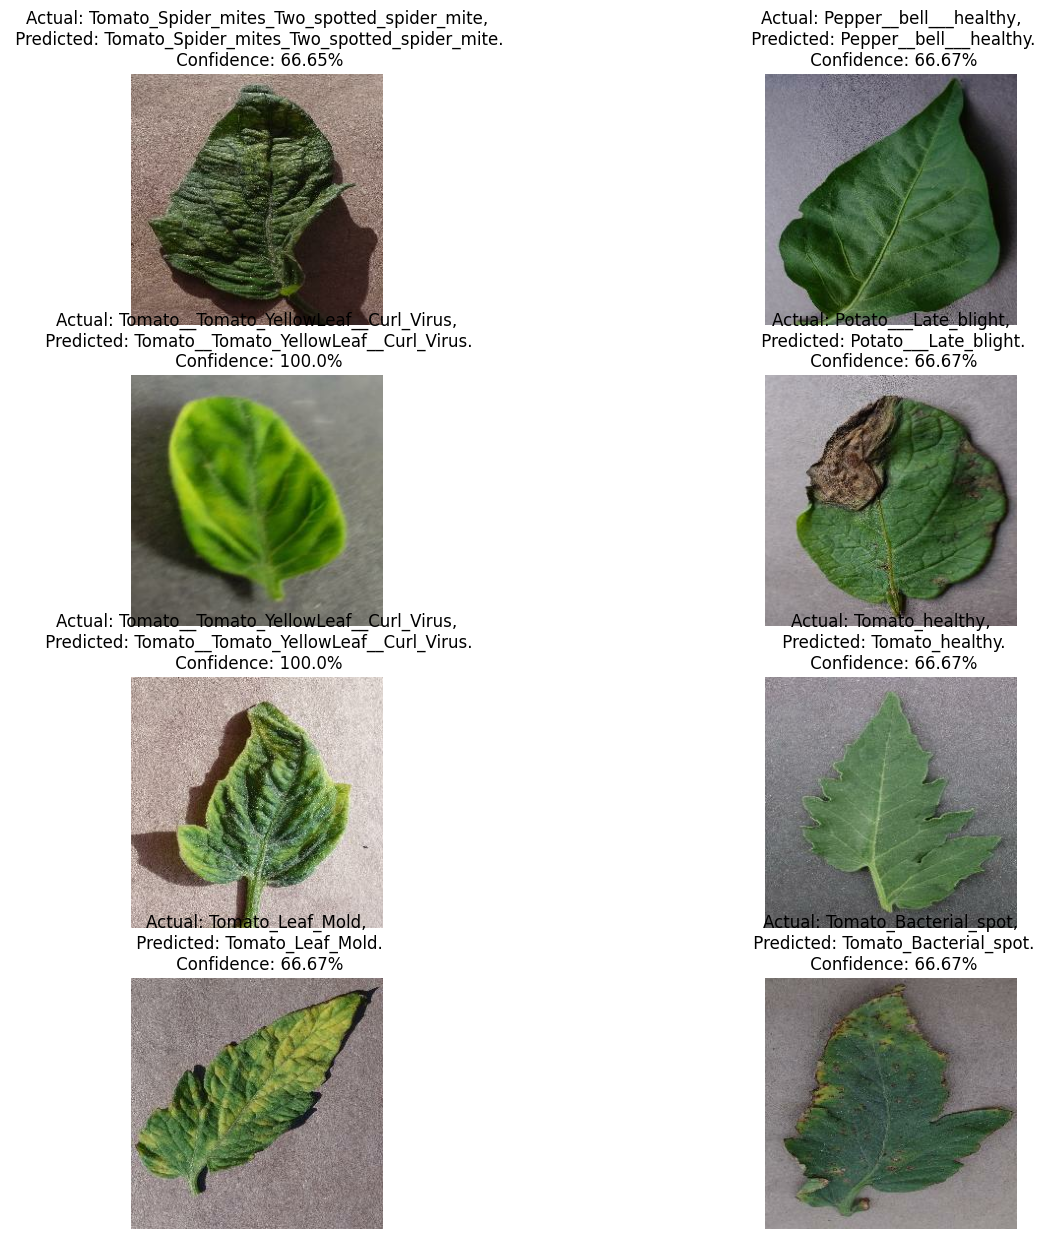

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(4, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(ensemble_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")